In [1]:
%load_ext autoreload
%autoreload 2

# Datapreparation For Neural Network MoA Prediction

In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

This funciton is used to balance the traingin datset. DMSO is overrepresented in the dataset. It got added to each plate as a negative control. Therefore we try to balance the training dataset by taking the mean of all compounds except DMSO and take a random sample of DMSO with `n = mean count`, so that all compounds have roughly the same number of samples.

In [3]:
def balance_train_data(df, label, group_lbl, count_lbl, random_state):
    """
    Balance the training dataset.
    Params:
        - df (Pandas dataframe): dataframe of the training dataset.
        - label (string): overrepresented compound.
        - group_lbl (string): label of the grouping column.
        - count_lbl (string): label of the counting column.
        - random_state (int): controls randomization, ensures reproducibility.
    """
    df_grp = df.groupby([group_lbl])[group_lbl].count().reset_index(name="count")
    mean_count = int(df_grp.drop(df_grp[df_grp[group_lbl] == label].index)["count"].mean().round())

    # Take a sample of size mean_count of the overrepresented compound/MoA
    df_label = df[df[group_lbl] == label].sample(n=mean_count, random_state=random_state)
    df_other = df.drop(df[df[group_lbl] == label].index)

    df_all = pd.concat([df_other, df_label], axis=0)
  
    return df_all.reset_index(drop=True)

Define paths, file names and random_state used in the notebook.

In [4]:
data_dir = "~/siads696/data"

# Input dataset
embed_dataset =  "bbbc021_image_embed_compact_batchcorr.csv"

# The pre-defined train-test-split
train_test_split = "compound_moas_trainVtest.csv"

train_data_moa_file = "full_train_moa.parquet"
test_data_file = "full_test.parquet"

random_state = 764

Load the dataset containing the batch corrected image embedding vectors.

In [5]:
df_dataset = pd.read_csv(os.path.join(data_dir, embed_dataset), dtype={"Metadata_MoA": "str", "Metadata_SMILES": "str"})

print(f"Embedding vector dataset shape: {df_dataset.shape}")
print(f"Embedding vectors MoA assigned: {df_dataset[~df_dataset['Metadata_MoA'].isnull()].shape[0]}")

Embedding vector dataset shape: (13200, 3081)
Embedding vectors MoA assigned: 6160


Load the train-test- split file and devide the dataframe into training and test compounds.

In [6]:
df_train_test = pd.read_csv(os.path.join(data_dir, train_test_split))
df_train = df_train_test[~df_train_test["in_testset"]]
df_test = df_train_test[df_train_test["in_testset"]]

In [7]:
print(f"Train/test set shape: {df_train_test.shape}")
print(f"Training set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")
print(f"\nMoA in training set:\n {", ".join(df_train['MoA'].unique().tolist())}")
print(f"\nMoA in test set:\n {", ".join(df_test['MoA'].unique().tolist())}")
print(f"\nCompounds in training set:\n {", ".join(df_train['Compound'].unique().tolist())}")
print(f"\nCompounds in test set:\n {", ".join(df_test['Compound'].unique().tolist())}")

Train/test set shape: (39, 4)
Training set shape: (29, 4)
Test set shape: (10, 4)

MoA in training set:
 Actin disruptors, Aurora kinase inhibitors, Cholesterol-lowering, DMSO, DNA damage, DNA replication, Eg5 inhibitors, Epithelial, Kinase inhibitors, Microtubule destabilizers, Microtubule stabilizers, Protein degradation, Protein synthesis

MoA in test set:
 Actin disruptors, Aurora kinase inhibitors, DNA damage, DNA replication, Epithelial, Kinase inhibitors, Microtubule destabilizers, Microtubule stabilizers, Protein degradation, Protein synthesis

Compounds in training set:
 cytochalasin B, cytochalasin D, AZ-A, AZ258, mevinolin/lovastatin, simvastatin, DMSO, chlorambucil, cisplatin, etoposide, camptothecin, floxuridine, methotrexate, AZ-C, AZ138, AZ-J, AZ-U, PD-169316, alsterpaullone, colchicine, demecolcine, nocodazole, docetaxel, epothilone B, ALLN, MG-132, lactacystin, anisomycin, cyclohexamide

Compounds in test set:
 latrunculin B, AZ841, mitomycin C, mitoxantrone, PP-2, bry

Merge the dataset with the training and test dataframes to create the training and test dataframes.

In [8]:
df_data_train = df_dataset.merge(df_train, left_on="Metadata_Compound", right_on="Compound", how="inner")
df_data_test = df_dataset.merge(df_test, left_on="Metadata_Compound", right_on="Compound", how="inner")

Visualize the distribution of th MoAs in the training dataset. It can be seen that DMSO is clearly overrepresented in the dataset.

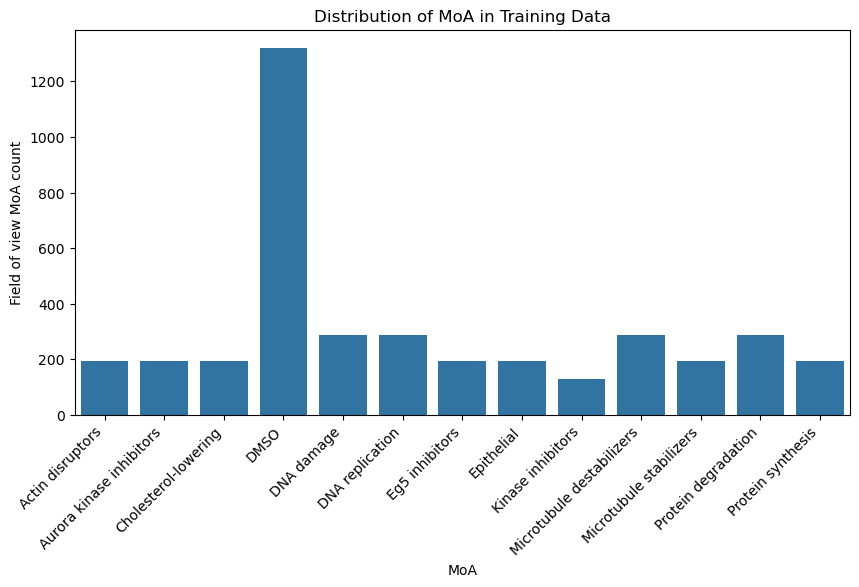

In [9]:
df_moa_count = df_data_train.groupby(["Metadata_MoA"])["Metadata_Compound"].count().reset_index(name="MoA_count")
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x="Metadata_MoA", y="MoA_count", data=df_moa_count, orient="v", ax=ax)
ax.set_ylabel("Field of view MoA count")
ax.set_xlabel("MoA")
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of MoA in Training Data")
plt.show()

Balance the training dataset by taking a random sample of DMSO in the size of the mean sample size of the other MoAs.

In [10]:
print(f"Training data shape before balancing: {df_data_train.shape}")
df_data_moa_train = balance_train_data(df_data_train, "DMSO", "Metadata_MoA", "Metadata_Compound", random_state)
print(f"Training data shape after balancing: {df_data_moa_train.shape}")

Training data shape before balancing: (3944, 3085)
Training data shape after balancing: (2843, 3085)


Visualize the balanced training dataset. It can be noticed that the dataset still contains some differences between the MoAs but it is far more balanced.

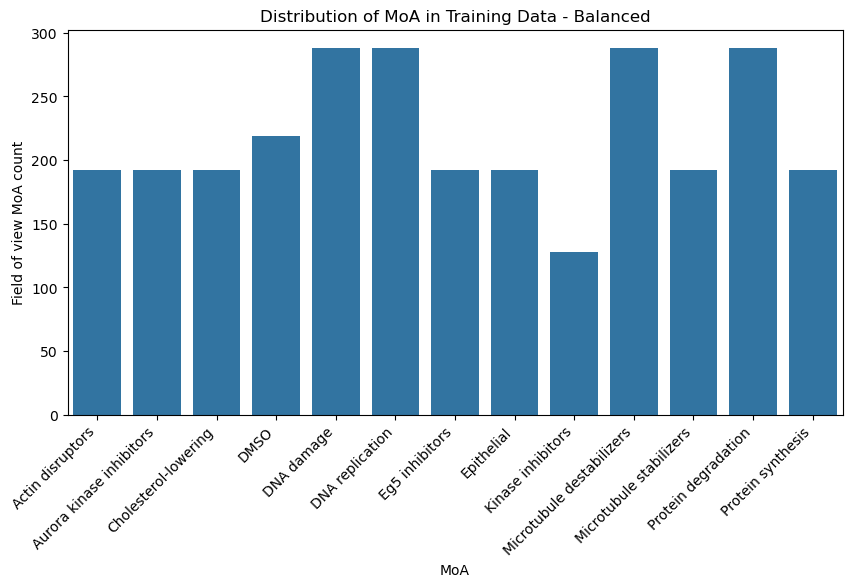

In [11]:
df_moa_count = df_data_moa_train.groupby(["Metadata_MoA"])["Metadata_Compound"].count().reset_index(name="MoA_count")
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x="Metadata_MoA", y="MoA_count", data=df_moa_count, orient="v", ax=ax)
ax.set_ylabel("Field of view MoA count")
ax.set_xlabel("MoA")
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of MoA in Training Data - Balanced")
plt.show()

Export the balanced training and test datasets to parquet files. These files have the advantage of being more compact due to automatic compression of the the data (snappy is used as a default compression here). In addition they also contain some metadata like the coulumn datatypes. Parquet is supported by libraries like Pandas and Polars therefore no special handling is needed when loading the files.

In [12]:
df_data_moa_train.to_parquet(os.path.join(data_dir, train_data_moa_file), index=False)
df_data_test.to_parquet(os.path.join(data_dir, test_data_file), index=False)